# Modeling
Build, train and tune ML models to predict heart disease using preprocessed data

In [70]:
# Load Libaries
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load the saved data splits
with open("../data/split_data/x_train.pkl", "rb") as f:
    x_train = pickle.load(f)

with open("../data/split_data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("../data/split_data/x_test.pkl", "rb") as f:
    x_test = pickle.load(f)

with open("../data/split_data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

---
## Dealing with Class Imbalance

Note that the dataset is imbalanced, where most entries belong to the "Absent" class for heart disease status. It is important to deal with this imbalance as it may cause the model to be bias and predict the majority class more. Oversampling to balance the classes in the training set will allow the model to better learn patterns associated with the minority class.

In [71]:
# Combine x_train and y_train for oversampling
training_data = pd.concat([x_train, y_train], axis = 1)

# Oversampling (for equal majority and minority class)
majority_class = training_data[training_data["heart_disease_status"] == 0]
minority_class = training_data[training_data["heart_disease_status"] == 1]
minority_oversampled = minority_class.sample(n = len(majority_class), replace = True, random_state = 1)

# New training data
training_data_balanced = pd.concat([majority_class, minority_oversampled])
training_data_balanced = training_data_balanced.sample(frac = 1, random_state = 1).reset_index(drop = True)

# Separate balanced training data
x_train_balanced = training_data_balanced.drop(columns = ["heart_disease_status"])
y_train_balanced = training_data_balanced["heart_disease_status"]

# After oversampling
print("Balanced training set distribution:")
print(y_train_balanced.value_counts())

Balanced training set distribution:
heart_disease_status
0    6400
1    6400
Name: count, dtype: int64


---
## Training and Comparing Models
A variety of modeling strategies will be used to find the best model for predicting heart disease. These models include:
- Logistic Regression (linear model)
- Random Forest (tree-based)
- K-Nearest Neighbours (distance-based)
- Support Vector Machine (margin-based)

Cross-validation will be used to compare each model and evaluate their performances on the training data.

Then, models will be further evaluated based on metrics like accuracy, F1 score and ROC AUC.

1. Logistic Regression

In [72]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, random_state=1))
])

scores_lr = cross_val_score(pipe_lr, x_train_balanced, y_train_balanced, cv=5, scoring="accuracy")
print(f"Logistic Regression CV Accuracy: {scores_lr.mean():.4f}")


Logistic Regression CV Accuracy: 0.5084


2. Random Forest

In [73]:
pipe_rf = Pipeline([
    ("model", RandomForestClassifier(random_state=1))
])

scores_rf = cross_val_score(pipe_rf, x_train_balanced, y_train_balanced, cv=5, scoring="accuracy")
print(f"Random Forest CV Accuracy: {scores_rf.mean():.4f}")

Random Forest CV Accuracy: 0.9798


3. Support Vector Machine (SVC)

In [74]:
pipe_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(probability=True, random_state=1))
])

scores_svc = cross_val_score(pipe_svc, x_train_balanced, y_train_balanced, cv=5, scoring="accuracy")
print(f"SVM CV Accuracy: {scores_svc.mean():.4f}")

SVM CV Accuracy: 0.7039


4. K-Nearest Neighbours (KNN)

In [75]:
pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

scores_knn = cross_val_score(pipe_knn, x_train_balanced, y_train_balanced, cv=5, scoring="accuracy")
print(f"KNN CV Accuracy: {scores_knn.mean():.4f}")

KNN CV Accuracy: 0.6945


In [76]:
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

def evaluate_model(name, pipeline):
    acc = cross_val_score(pipeline, x_train_balanced, y_train_balanced, cv=5, scoring="accuracy").mean()
    f1 = cross_val_score(pipeline, x_train_balanced, y_train_balanced, cv=5, scoring="f1").mean()
    roc = cross_val_score(pipeline, x_train_balanced, y_train_balanced, cv=5, scoring="roc_auc").mean()
    
    print(f"{name} CV Scores:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print(f"  ROC AUC  : {roc:.4f}")
    print()

evaluate_model("Logistic Regression", pipe_lr)
evaluate_model("Random Forest", pipe_rf)
evaluate_model("SVM", pipe_svc)
evaluate_model("KNN", pipe_knn)

Logistic Regression CV Scores:
  Accuracy : 0.5084
  F1 Score : 0.5060
  ROC AUC  : 0.5145

Random Forest CV Scores:
  Accuracy : 0.9798
  F1 Score : 0.9794
  ROC AUC  : 0.9825

SVM CV Scores:
  Accuracy : 0.7039
  F1 Score : 0.7210
  ROC AUC  : 0.7799

KNN CV Scores:
  Accuracy : 0.6945
  F1 Score : 0.7296
  ROC AUC  : 0.7705



In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(x_train_balanced, y_train_balanced)

print("Best parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [78]:
# Refit the best model explicitly on the full balanced training set
best_rf.fit(x_train_balanced, y_train_balanced)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


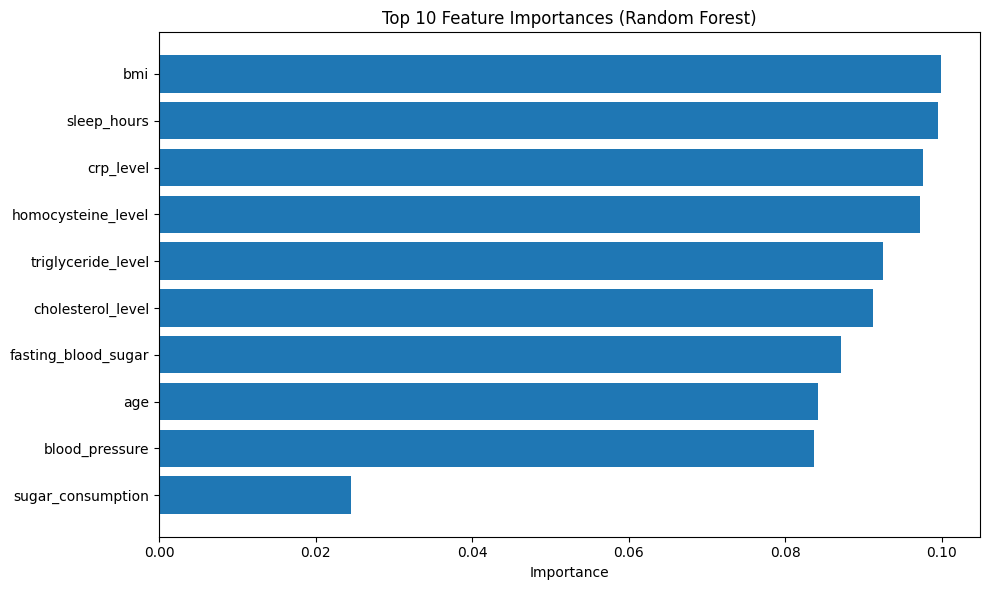

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# Get and plot top 10 most important features
importances = best_rf.feature_importances_
features = x_train_balanced.columns

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:10], importance_df["Importance"][:10])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [82]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Predict probabilities for class 1 ("Present")
y_proba = best_rf.predict_proba(x_test)[:, 1]

# Apply threshold
# If your goal is to catch more positive cases (heart disease present), you might accept more false positives to increase recall. By lowering the threshold from 0.5 to 0.3, you predict positive more often.
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.71      0.75      1600
           1       0.19      0.27      0.22       400

    accuracy                           0.62      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.67      0.62      0.64      2000

=== Confusion Matrix ===


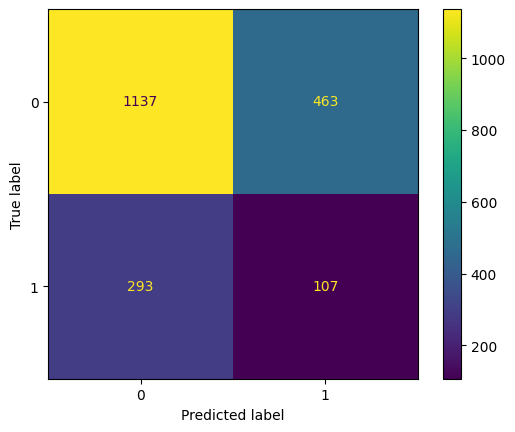

Test ROC AUC Score: 0.5035


In [81]:
# Classification report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("=== Confusion Matrix ===")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC AUC Score: {roc_auc:.4f}")

✅ 1. Modeling Notebook
Purpose: Build, train, and tune machine learning models.

What to include:

Load preprocessed & split data (e.g., from a .pkl file)

Oversample training data

Train multiple models (e.g., Random Forest, Logistic Regression)

Use cross-validation

Hyperparameter tuning (GridSearchCV, RandomizedSearchCV)

Select the best model based on metrics

Make predictions on test data

Save the best model